# $\S 1.2$ Solution of nolinear equation
---

In this lab, I will test three algorithms of solving no-linear equation about their correctness and efficiency, they are: 
- Bisection Method
- Newton's Method
- Secant Method   
And then use them to solve the problem 3 in instruction book.

# 1. realization of these algorithms 

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

## 1.0. preparations 

Losses varies for different algorithms here. But for all algorithms, the loss can be defined as:  
$$
|x^{(k)} - x^{*}| \le e(x^{(k)}) \tag{1}
$$
so according to different algorithms, we can defined different losses. 
1. bisection method:  
$$
e(x^{(k)}) = {b - a \over 2^{k+1}} \tag{2}
$$


In [42]:
def Lsection(a, b, k):
    return (b - a) / 2**(k+1)

2. Newtown's method: ($p = 2$)   
$$
e(x^{(k)}) \le {1\over2}{|\phi ^{''}(\epsilon_k)|e(x^{(k-1)})^2} \tag{3}
$$  
In particular, $e(x^(0))=$
where $\epsilon_k \in [x^*, x^{(k)}]$  (we suppose that $x^*\lt x^{(k)}$).    
And according to its iteration formular, we get: 
$$
\phi^{''}(x)={f(x)f^{'}(x)f^{'''}(x)+f^{'}(x)^2f^{''}(x)-2f(x)f^{''}(x)^2 \over f^{'}(x)^3} \tag{4}
$$

In [43]:
def Lnewton(fl, x_new, elast):
    if len(fl) < 4:
        raise ValueError('at least 3rd order derivative is needed')
    M0 = fl[0](x_new)
    M1 = fl[1](x_new)
    M2 = fl[2](x_new)
    M3 = fl[3](x_new)
    M = (M0*M1*M3 + M1*M1*M2 - 2*M0*M2*M2) / (M1**3)
    return M * elast**2 / 2


3. Secant method: ($p = {1 + \sqrt 5 \over 2}$)
$$
e(x^{(k)}) \le |\phi^{'}(\epsilon_n)|e(x^{(k-1)}) \tag{4}
$$

In [44]:
def Lsecant(M, elast):
    return M * elast

## 1.1. bisection method

In [45]:
def bisection_method(fl, a, b, tol=1e-6, max_iter=10000):
    """
    Implementation of the bisection method for finding roots of a given function.

    Args:
        fl (list): A list containing the function to be evaluated.
        a (float): The left endpoint of the interval.
        b (float): The right endpoint of the interval.
        tol (float, optional): The tolerance for convergence. Defaults to 1e-6.
        max_iter (int, optional): The maximum number of iterations. Defaults to 10000.

    Returns:
        tuple: A tuple containing the root and a list of losses if a root is found.
               If no root is found within the interval, returns (-1, []).
               If the maximum number of iterations is reached without convergence, raises a ValueError.

    Raises:
        ValueError: If the maximum number of iterations is reached without convergence.

    """
    ll = []  # List to store the loss values at each iteration
    if fl[0](a) * fl[0](b) > 0:
        return -1, []  # If the sign of the function values at a and b are the same, no root is found
    for j in range(max_iter):
        c = (a + b) / 2  # Calculate the midpoint of the interval
        loss = Lsection(a, b, j)  # Calculate the loss at the midpoint
        ll.append(loss)  # Append the loss to the list

        if fl[0](c) == 0 or loss < tol:
            return c, ll  # If the function value at the midpoint is zero or the loss is within the tolerance, a root is found
        if fl[0](c) * fl[0](a) < 0:
            b = c  # If the sign of the function value at the midpoint is opposite to the sign of the function value at a, update b to the midpoint
        else:
            a = c  # Otherwise, update a to the midpoint
    raise ValueError("Bisection method did not converge within the maximum number of iterations.")  # If the maximum number of iterations is reached without convergence, raise a ValueError

## 1.2. the Newton's method 
iteration formular: 
$$
x^{(k+1)} = {x^{(k)} - f(x^{(k)}) \over f^{'}(x^{(k)})}
$$

In [46]:
def newton_method(fl, x0, tol=1e-6, miter=10000):
    """
    Newton's method is an iterative algorithm used to find the roots of a function.
    It approximates the root by iteratively updating the current approximation.

    Args:
        fl (list): List of functions representing the equation whose roots are to be found.
            fl[0] is the function and fl[1] is its first derivative.
        x0 (float): Initial value for the Newton's method.
        tol (float, optional): Tolerance for the root finding algorithm. Defaults to 1e-6.
        miter (int, optional): Maximum number of iterations. Defaults to 10000.

    Returns:
        tuple: A tuple containing the approximate root and a list of losses.
            The approximate root is the value that satisfies the equation.
            The list of losses is the error of the method at each iteration.

    Raises:
        ValueError: If the Newton's method does not converge within the maximum number of iterations.
    """

    ll = []  # List to store the losses
    x = x0  # Current approximation

    for j in range(miter):
        x_new = x - fl[0](x) / fl[1](x)  # Calculate the new approximation using the Newton's method formula

        if j == 0:
            loss = abs(x_new - x)  # Calculate the initial loss
            ll.append(loss)
        else:
            loss = Lnewton(fl, x_new, ll[-1])  # Calculate the error of the method at each iteration
            ll.append(loss)

        if loss < tol:
            return x_new, ll
        else:
            x = x_new

    raise ValueError("Newton's method did not converge within the maximum number of iterations.")

## 1.3. Secant Method (optimized Newton's method)   
iteration formular:  
1. double point:  
$$
x^{(k+1)} = {x^{(k)}-f(x^{k}) \over f(x^{k})-f(x^{(k-1)})} (x^{(k)}-x^{(k-1)})
$$
2. single point:
$$
x^{(k+1)} = {x^{(k)}-f(x^{k}) \over f(x^{k})-f(x^{(0)})} (x^{(k)}-x^{(0)})
$$

In [47]:
def secant_method(fl, x0, x1, tol=1e-6, miter=10000):
    """
    Implementation of the Secant method for finding roots of a function.

    Args:
        fl (list): List of functions representing the equation whose roots are to be found.
        x0 (float): Initial value for the secant method.
        x1 (float): Second initial value for the secant method.
        tol (float, optional): Tolerance for the root finding algorithm. Defaults to 1e-6.
        miter (int, optional): Maximum number of iterations. Defaults to 10000.

    Returns:
        tuple: A tuple containing the approximate root and a list of losses.

    Raises:
        ValueError: If the Secant method does not converge within the maximum number of iterations.
    """

    ll = []  # List to store the losses
    rec = x0  # Previous approximation

    for _ in range(miter):
        ty = 'double'  # Type of calculation (double or single)

        if ty == 'double':
            # Calculate the new approximation using the secant method formula
            x_new = x1 - fl[0](x1) * (x1 - x0) / (fl[0](x1) - fl[0](x0))
        else:
            # Calculate the new approximation using the secant method formula
            x_new = x1 - fl[0](x1) * (x1 - rec) / (fl[0](x1) - fl[0](rec))

        loss = abs(x_new - x1)  # Calculate the loss between the current approximation and the previous approximation
        ll.append(loss)  # Append the loss to the list of losses

        if loss < tol:
            return x_new, ll  # Return the approximate root and the list of losses if the loss is below the tolerance

        x0, x1 = x1, x_new  # Update the previous approximation and the current approximation

    raise ValueError("Secant method did not converge within the maximum number of iterations.")

I will use the loss as metric to visualize the convergency of algorithm. 

In [48]:
def visualize(ll1, ll2, ll3):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(ll1)), ll1, label='Bisection Method')
    plt.plot(range(len(ll2)), ll2, label='Newton Method')
    plt.plot(range(len(ll3)), ll3, label='Secant Method')
    plt.legend()
    plt.title('Loss of three methods')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()


Root using scipy           : 2.783303038633285
Root using Bisection Method: 2.78369140625
Root using Newtons Method  : 2.7833030386332824
Root using Secant Method   : 2.783303038631453


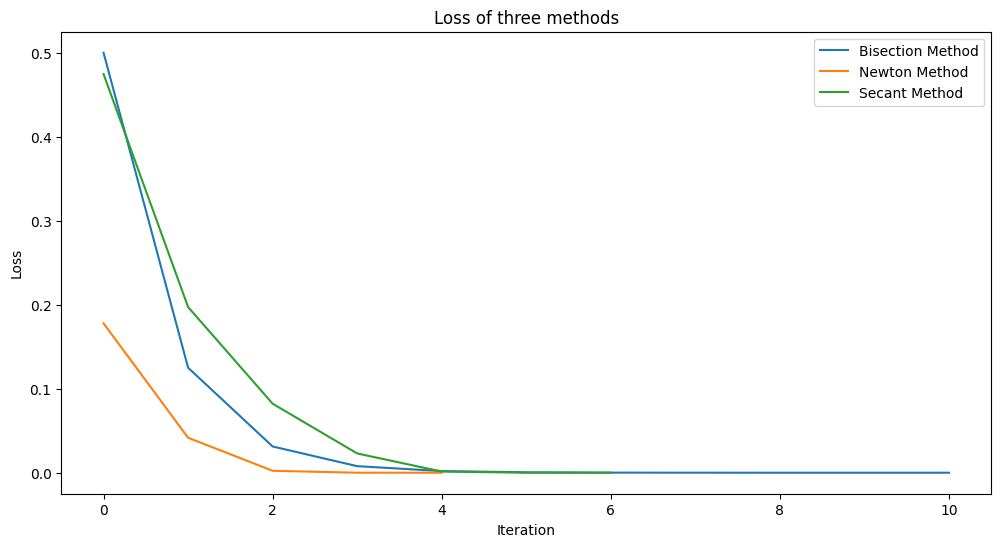

Root using scipy           : 6.532235591097831
Root using Bisection Method: 6.53271484375
Root using Newtons Method  : 6.53223559109783
Root using Secant Method   : 6.532235591097646


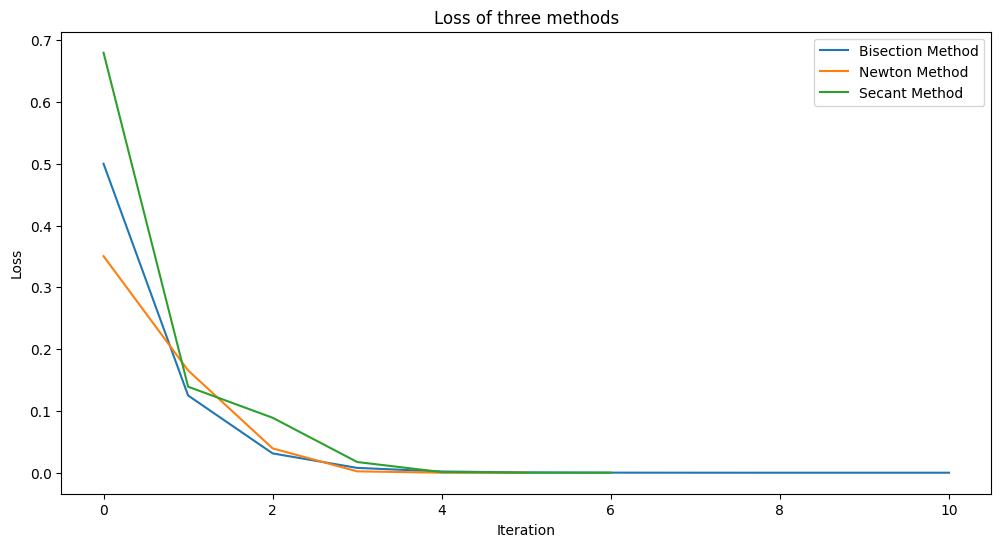

Root using scipy           : 9.374930514362685
Root using Bisection Method: 9.37451171875
Root using Newtons Method  : 9.374930514362152
Root using Secant Method   : 9.374930514355318


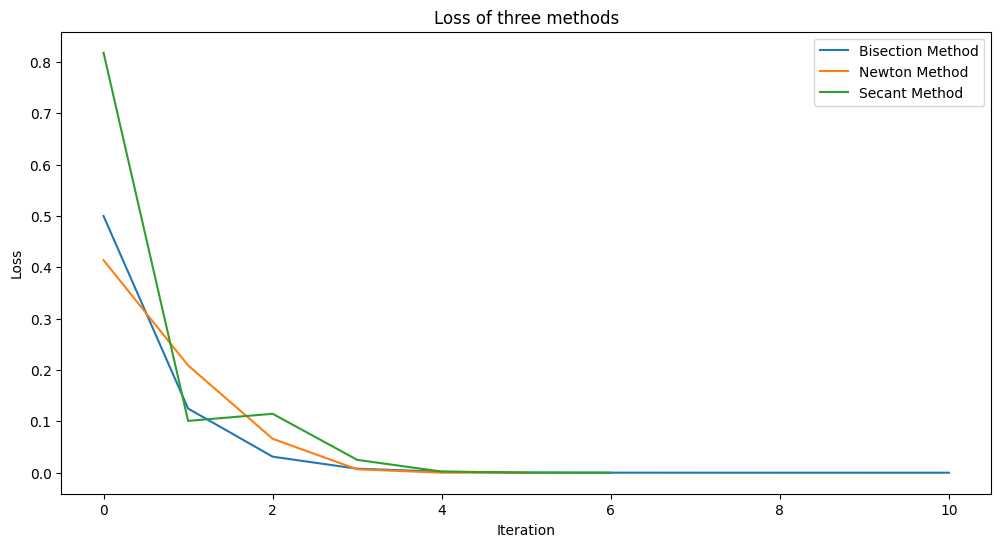

In [49]:
fl = [
    lambda x: np.exp(x) * np.sin(x) - (x - 1)**3, 
    lambda x: np.exp(x) * (np.sin(x) + np.cos(x)) - 3 * (x - 1)**2, 
    lambda x: np.exp(x) * (np.sin(x) + np.cos(x)) + 2 * np.exp(x) * np.cos(x) - 6 * (x - 1),
    lambda x: 2*(-np.exp(x)*np.sin(x) + np.exp(x)*np.cos(x) - 3)
]

for i in range(1, 11, 1):  
    if fl[0](i) == 0:
        print(f'{i} is a root')
    elif fl[0](i-1) * fl[0](i) < 0:
        root = opt.root(fl[0], i)
        print(f'Root using scipy           : {root.x.item()}')
        root, ll1 = bisection_method(fl, i-1, i)
        print(f'Root using Bisection Method: {root}')
        root, ll2 = newton_method(fl, i)
        print(f'Root using Newtons Method  : {root}')
        root, ll3 = secant_method(fl, i-1, i)
        print(f'Root using Secant Method   : {root}')

        visualize(ll1, ll2, ll3)



<center>  

**Figure 1.** loss and iteration of three methods


# 3. solution of problems 

## 3.1. problem 3

After modeling, our task is finding out a root $h^*$ following equation: 
$$
h^3-30h^2+1448=0
$$
where: $\ 0\le h^*\le 10$  

Root using scipy           : 8.13849849187965
Root using Bisection Method: 8.13818359375
Root using Newtons Method  : 8.138498491879586
Root using Secant Method   : 8.138498491879586


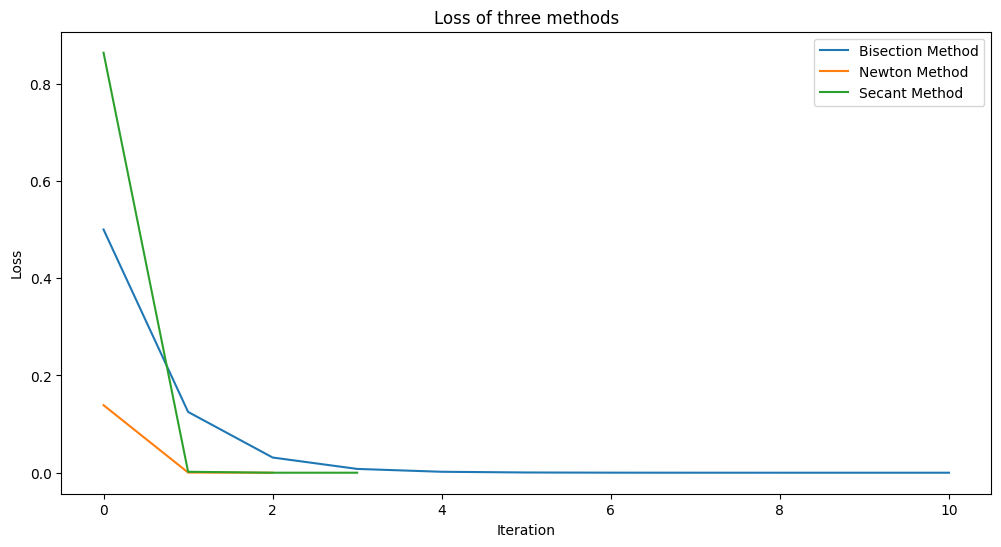

In [50]:
fl = [
    lambda x: x**3 - 30*x**2 + 1448,
    lambda x: 3*x**2 - 60*x,
    lambda x: 6*x - 60,
    lambda x: 6
]


for i in range(1, 11, 1):  
    if fl[0](i) == 0:
        print(f'{i} is a root')
    elif fl[0](i-1) * fl[0](i) < 0:
        root = opt.root(fl[0], i)
        print(f'Root using scipy           : {root.x.item()}')
        root, ll1 = bisection_method(fl, i-1, i)
        print(f'Root using Bisection Method: {root}')
        root, ll2 = newton_method(fl, i-1)
        print(f'Root using Newtons Method  : {root}')
        root, ll3 = secant_method(fl, i-1, i)
        print(f'Root using Secant Method   : {root}')

        visualize(ll1, ll2, ll3)



<center>  

**Figure 2.** comparison between three methods on problem 3